In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import product

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from copy import deepcopy
from sklearn.base import clone

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

# SELETOR

In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
class ModelSelector:
    options = {
        # ---------------- Linear Models ----------------
        'linear_regression': {
            'model': LinearRegression(),
            'params': {}  # sem hiperparâmetros principais
        },
        'ridge': {
            'model': Ridge(),
            'params': {'alpha': [0.01, 0.1, 1, 10, 100, 200, 500, 1000]}
        },
        'lasso': {
            'model': Lasso(),
            'params': {'alpha': [0.001, 0.01, 0.1, 1, 10]}
        },
        'elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.001, 0.01, 0.1, 1, 10],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
            }
        },
        'huber': {
            'model': HuberRegressor(),
            'params': {'epsilon': [1.1, 1.3, 1.5, 1.7], 'alpha': [0.0001, 0.001, 0.01]}
        },

        # ---------------- Tree-based Models ----------------
        'decision_tree': {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'max_depth': [None, 5, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'extra_trees': {
            'model': ExtraTreesRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'gradient_boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        },

        # ---------------- Advanced Ensemble Models ----------------
        'xgboost': {
            'model': XGBRegressor(random_state=42, objective='reg:squarederror'),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'max_depth': [3, 5, 7],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0]
            }
        },
        'lightgbm': {
            'model': LGBMRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'num_leaves': [31, 63, 127],
                'max_depth': [-1, 10, 20]
            }
        },
        'catboost': {
            'model': CatBoostRegressor(random_state=42, verbose=0),
            'params': {
                'iterations': [200, 500],
                'learning_rate': [0.01, 0.05, 0.1],
                'depth': [4, 6, 8]
            }
        },

        # ---------------- Kernel & Neural Models ----------------
        'svr': {
            'model': SVR(),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'mlp': {
            'model': MLPRegressor(max_iter=1000, random_state=42),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (100, 50)],
                'activation': ['relu', 'tanh'],
                'solver': ['adam', 'lbfgs'],
                'learning_rate_init': [0.001, 0.01]
            }
        }
    }

    def get(self):
        model = Pipeline([
            ('scaler', StandardScaler()), 
            ('model', self.selected['model'])
        ])
        
        raw_params = self.selected['params']
        params = {f'model__{k}': v for k, v in raw_params.items()}
        return model, params

    def __init__(self, name: str):
        self.chosen   = name
        self.selected = self.options[name]

In [4]:
selector = ModelSelector('gradient_boosting')
model, params = selector.get()
model

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0


# EXTRAINDO DADOS

In [5]:
df = pd.read_csv('files/DataBase.csv')
df

,wx,wx(n-1),wx(n-2),wx(n-3),wx(n-4),wx(n-5),wx(n-6),wx(n-7),wx(n-8),wx(n-9),...,wy(n-40),wy(n-41),wy(n-42),wy(n-43),wy(n-44),wy(n-45),wy(n-46),wy(n-47),wy(n-48),wy(n-49)
0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.0,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.0,-3.0,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,-10.0,-7.0,-7.0,...,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0,-10.0,-10.0,-11.0
1636,4.0,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,-10.0,-7.0,...,-19.0,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0,-10.0,-10.0
1637,4.0,4.0,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,-10.0,...,-16.0,-19.0,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0,-10.0
1638,4.0,4.0,4.0,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,...,-16.0,-16.0,-19.0,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0


In [6]:
xData = df.drop(columns=['pitch'])
yData = df['pitch']

# MODELO

In [7]:
K_FOLD = 5

In [8]:
grid = GridSearchCV(model, params, cv=TimeSeriesSplit(n_splits=K_FOLD), scoring='r2', n_jobs=-1)
grid.fit(xData, yData)

print('Best Params:', grid.best_params_)
print('Best R²:    ', grid.best_score_)
grid.best_estimator_

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300}
Best R²:     0.7294406132251726


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,learning_rate,0.1
,n_estimators,300
,subsample,1.0


,name,values,mean,std,min,max,k0,k1,k2,k3,k4
0,r2,"[0.15313520796374303, 0.9265968208092845, 0.96...",0.729441,0.301170,0.153135,0.968342,0.153135,0.926597,0.968342,0.887908,0.711221
1,r2_adj,"[2.3013967425641915, 1.1128003657620034, 1.048...",1.415775,0.462815,1.048649,2.301397,2.301397,1.112800,1.048649,1.172255,1.443773
2,rmse,"[808.0765204293115, 57.08297983436447, 11.3819...",177.291000,315.995729,3.912394,808.076520,808.076520,57.082980,11.381903,6.001205,3.912394
3,mae,"[666.4537399081629, 44.05120512314302, 9.14936...",145.589451,260.859999,3.161082,666.453740,666.453740,44.051205,9.149362,5.131865,3.161082
4,mape,"[0.12213587879186448, 0.008429740150663327, 0....",0.026785,0.047761,0.000606,0.122136,0.122136,0.008430,0.001766,0.000988,0.000606


R2: 0.729441 (±0.301170)
R2_ADJ: 1.415775 (±0.462815)
RMSE: 177.291000 (±315.995729)
MAE: 145.589451 (±260.859999)
MAPE: 0.026785 (±0.047761)


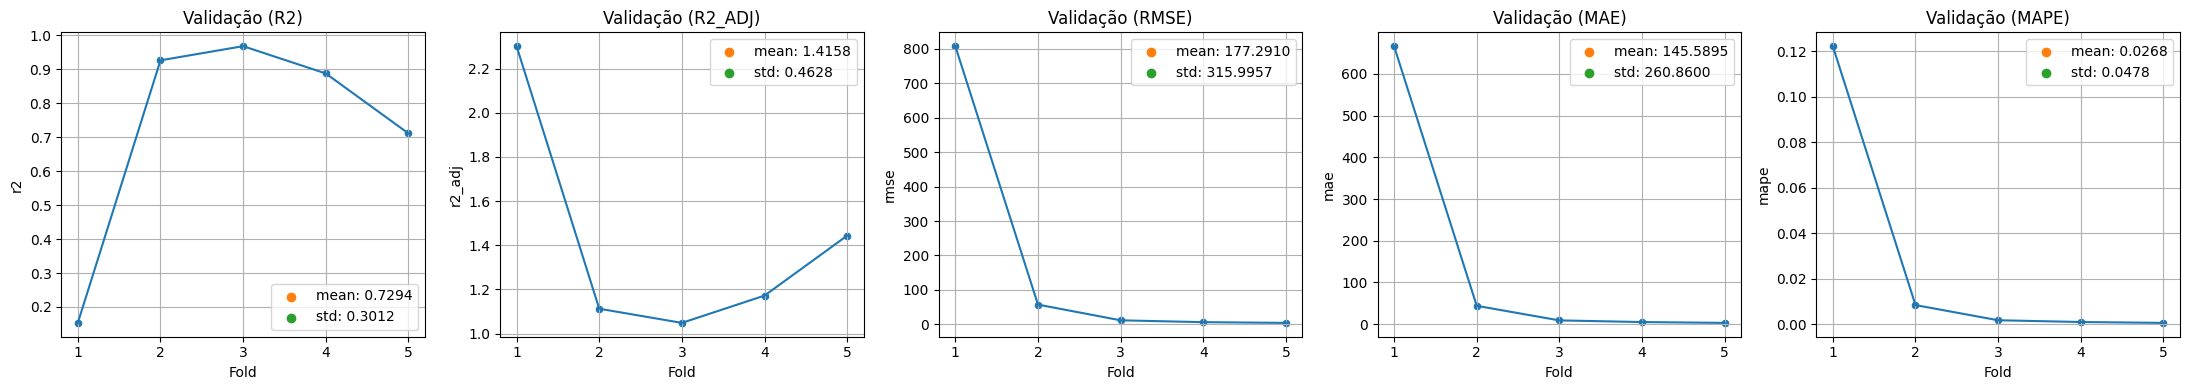

In [ ]:
class CrossValidation:
    def __init__(self, model, xData, yData, k=4, seed=42):
        self.selected = str(model.__class__.__name__)
        self.xData = np.asarray(xData)
        self.yData = np.asarray(yData)
        self.model = clone(model)
        self.seed = seed
        self.k = k

        self.scores = {}
        self.df    = None

    def update(self):
        self.results  = {'r2': [], 'r2_adj': [], 'rmse': [], 'mae': [], 'mape': []}
        self.splitter = TimeSeriesSplit(n_splits=self.k)
        
        p = self.xData.shape[1] if self.xData.ndim > 1 else 1
        self.graph = {'yTest': [], 'yModel': []}

        for train_index, val_index in self.splitter.split(self.xData):
            xTrain, xTest = self.xData[train_index], self.xData[val_index]
            yTrain, yTest = self.yData[train_index], self.yData[val_index]
            n = len(yTest)

            model = deepcopy(self.model)
            model.fit(xTrain, yTrain)
            
            yModel = model.predict(xTest)
            r2     = r2_score(yTest, yModel)
            
            r2a  = 1.0 - (1.0 - r2) * (n - 1) / (n - p - 1)
            rmse = np.sqrt(mean_squared_error(yTest, yModel))
            mae  = mean_absolute_error(yTest, yModel)
            mape = mean_absolute_percentage_error(yTest[np.abs(yTest)>1e-8], yModel[np.abs(yTest)>1e-8])
            
            self.graph['yTest'].extend(yTest)
            self.graph['yModel'].extend(yModel)

            self.results['r2'].append(r2)
            self.results['r2_adj'].append(r2a)
            self.results['rmse'].append(rmse)
            self.results['mae'].append(mae)
            self.results['mape'].append(mape)

        self.df = pd.DataFrame([self.getStats(name, values) for name, values in self.results.items()])
        self.r2     = float(self.df.loc[self.df.name=='r2','mean'].iloc[0])
        self.r2_adj = float(self.df.loc[self.df.name=='r2_adj','mean'].iloc[0])
        self.rmse = float(self.df.loc[self.df.name=='rmse','mean'].iloc[0])
        self.mae  = float(self.df.loc[self.df.name=='mae','mean'].iloc[0])
        self.mape = float(self.df.loc[self.df.name=='mape','mean'].iloc[0])


    def getStats(self, name, values):
        values = np.array(values, dtype=float)
        entry  = {
            'name': name,
            'values': values,
            'mean': np.nanmean(values),
            'std':  np.nanstd(values),
            'min':  np.nanmin(values),
            'max':  np.nanmax(values),
        }
        
        entry.update({f'k{i}': v for i, v in enumerate(values)})
        return entry

    def info(self):
        return {
            'model': self.selected,
            'r2': self.r2,
            'r2_adjusted': self.r2_adj,
            'rmse': self.rmse,
            'mae': self.mae,
            'mape': self.mape,
        }

    def print(self):
        display(self.df)
        for _, metric in self.df.iterrows():
            name = metric['name'].upper()
            mean = metric['mean']
            std  = metric['std']
            if name in ('RMSE','MAE','MAPE'):
                print(f'{name}: {mean:.6f} (±{std:.6f})')
            else:
                print(f'{name}: {mean:.6f} (±{std:.6f})')
    
    def plot(self):
        plt.figure(figsize=(22, 4))
        for i, row in self.df.iterrows():
            metric, values = row['name'], row['values']
            kData = [j+1 for j in range(len(values))]

            plt.subplot(1, len(self.df), i+1)
            plt.plot(kData, values)
            plt.scatter(kData, values, s=20)
            for info in ['mean', 'std']:
                plt.scatter([], [], label=f'{info}: {row[info]:.4f}')
            plt.xticks(kData); plt.title(f'Validação ({metric.upper()})')
            plt.grid(); plt.xlabel('Fold'); plt.ylabel(metric); plt.legend()
        plt.tight_layout()
        plt.show()


a

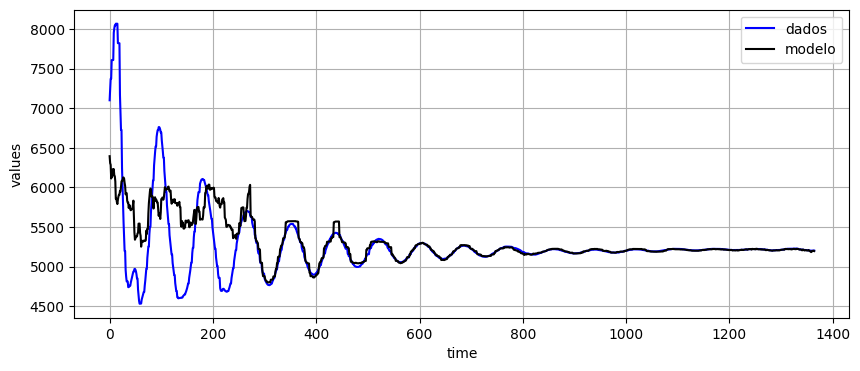

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(cross.graph['yTest'], color='blue', label='dados')
plt.plot(cross.graph['yModel'], color='black', label='modelo')
plt.legend()
plt.xlabel('time'); plt.ylabel('values')
plt.grid()

In [11]:
xData.columns

Index(['wx', 'wx(n-1)', 'wx(n-2)', 'wx(n-3)', 'wx(n-4)', 'wx(n-5)', 'wx(n-6)',
       'wx(n-7)', 'wx(n-8)', 'wx(n-9)',
       ...
       'wy(n-40)', 'wy(n-41)', 'wy(n-42)', 'wy(n-43)', 'wy(n-44)', 'wy(n-45)',
       'wy(n-46)', 'wy(n-47)', 'wy(n-48)', 'wy(n-49)'],
      dtype='object', length=449)